# Import Modules

In [1]:
import dataset as ds
import config as cfg
from evaluate import Evaluate

from sklearn.model_selection import train_test_split
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Rescaling, Dropout
from tensorflow.keras.metrics import Precision, Recall

from clearml import Task
import clearml
clearml.browser_login()


# ClearML
https://app.clear.ml/dashboard

# Import Dataset

In [2]:
# Base paths for the images and labels
train_images_path = f'{cfg.BASE_DATASET}/images/train'
train_labels_path = f'{cfg.BASE_DATASET}/labels/train'
val_images_path = f'{cfg.BASE_DATASET}/images/valid'
val_labels_path = f'{cfg.BASE_DATASET}/labels/valid'

# Base path for metadata
metadata_path = f'{cfg.BASE_DATASET}/metadata.json'

# Create the DataFrames for the train and validation sets
train_df = ds.create_dataframe(train_images_path, train_labels_path, metadata_path)
valid_df = ds.create_dataframe(val_images_path, val_labels_path, metadata_path)

# Test Parameters

In [3]:
project_name= cfg.PROJECT_NAME + '/tf_clf'
dataset_name = 'test500'
dataset_dir = cfg.CLF_DATASET_DIR + f'/{dataset_name}'
project_dir = f'{cfg.CLF_PROJECT_DIR}/{dataset_name}/'
class_names = cfg.CLF_CLASS_NAMES

zoom_factor = 1.5

epochs = 20
N = 10


_, test_train_df = train_test_split(
    train_df,
    test_size=500,  # Number of items you want in your sample
    stratify=train_df['ac'],  # Stratify based on the combined column
    #random_state=42  # Ensures reproducibility
)

_, test_val_df = train_test_split(
    valid_df,
    test_size=100,  # Number of items you want in your sample
    stratify=valid_df['ac'],  # Stratify based on the combined column
    #random_state=42  # Ensures reproducibility
)

ds.create_sub_dataset(dataset_dir, test_train_df, test_val_df, class_names)


Removing dataset if pre-existing
Copying training files:


Copying files:   0%|          | 0/1000 [00:00<?, ?it/s]

Copying validation files:


Copying files:   0%|          | 0/200 [00:00<?, ?it/s]

Dataset 'test500' created at C:\github\Third-Year-Project\Intruder-Aircraft-Detection\datasets\Custom\test500


In [4]:
# Pre-processing to AID classification

ds.pre_process_dataset_for_classification(dataset_dir, zoom_factor)


Processing images:   0%|          | 0/500 [00:00<?, ?it/s]

An error occurred with C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500\images\train\28857.jpg: Expected y_min for bbox (0.2490575, -0.07570950000000001, 0.9783645000000001, 0.4104955, 0) to be in the range [0.0, 1.0], got -0.07570950000000001.
An error occurred with C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500\images\train\31517.jpg: Expected y_min for bbox (0.44744949999999994, -0.0012459999999999971, 1.0929405, 0.42908199999999996, 0) to be in the range [0.0, 1.0], got -0.0012459999999999971.
An error occurred with C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500\images\train\44231.jpg: Expected y_max for bbox (0.606789, 0.781259, 0.935547, 1.000431, 0) to be in the range [0.0, 1.0], got 1.000431.
An error occurred with C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500\images\train\46211.jpg: Expected x_min for bbox (-0.00964100000000001, 0.1821015000000

Processing images:   0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
ds.correct_dataset_labels(dataset_dir, test_train_df, test_val_df, class_names)

Processing train labels in test500:


Processing labels:   0%|          | 0/500 [00:00<?, ?it/s]

File not found: C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500/labels/train\31517.txt
File not found: C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500/labels/train\44231.txt
File not found: C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500/labels/train\54877.txt
File not found: C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500/labels/train\46211.txt
File not found: C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500/labels/train\51292.txt
File not found: C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500/labels/train\28857.txt
File not found: C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500/labels/train\63802.txt
Processing valid labels in test500:


Processing labels:   0%|          | 0/100 [00:00<?, ?it/s]

Label correction completed.


In [6]:
augmentation_metadata = {
    'methods': {        
        'flip': {
            'parameters': {
                'orientation': 'h',  # Could be 'h' for horizontal or 'v' for vertical
                'p': 1.0  # Probability of applying the augmentation
            },
            'apply_to_percentage': 0.5  # 50% of the training images
        }        
    }
}

ds.augment_dataset(dataset_dir, augmentation_metadata)

Removing existing directories/files:   0%|          | 0/3 [00:00<?, ?it/s]

Copying files:   0%|          | 0/493 [00:00<?, ?it/s]

Copying files:   0%|          | 0/493 [00:00<?, ?it/s]

Applying augmentations:   0%|          | 0/246 [00:00<?, ?it/s]

In [7]:
ds.reorganize_dataset_for_keras(dataset_dir)

Moving images in train:   0%|          | 0/493 [00:00<?, ?it/s]

Moving images in train-aug:   0%|          | 0/739 [00:00<?, ?it/s]

Moving images in valid:   0%|          | 0/100 [00:00<?, ?it/s]

# Image Classifier

In [8]:
tf.keras.utils.set_random_seed(42)

In [9]:

train_dir = os.path.join(dataset_dir,'images','train')
train_aug_dir = os.path.join(dataset_dir,'images','train-aug')
valid_dir = os.path.join(dataset_dir,'images','valid')

batch_size = 32
img_height = 256
img_width = 256

# load datasets using keras
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    seed=42,
    image_size=(img_height, img_width),
    shuffle=True)

train_aug_data = tf.keras.utils.image_dataset_from_directory(
    train_aug_dir,
    batch_size=batch_size,
    seed=42,
    image_size=(img_height, img_width),
    shuffle=True)

valid_data = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    batch_size=batch_size,
    seed=42,
    image_size=(img_height, img_width),    
    shuffle=True)

class_names = train_data.class_names
print(class_names)



Found 493 files belonging to 3 classes.
Found 739 files belonging to 3 classes.
Found 100 files belonging to 3 classes.
['Boeing 737-800', 'Cessna Skyhawk', 'King Air C90']


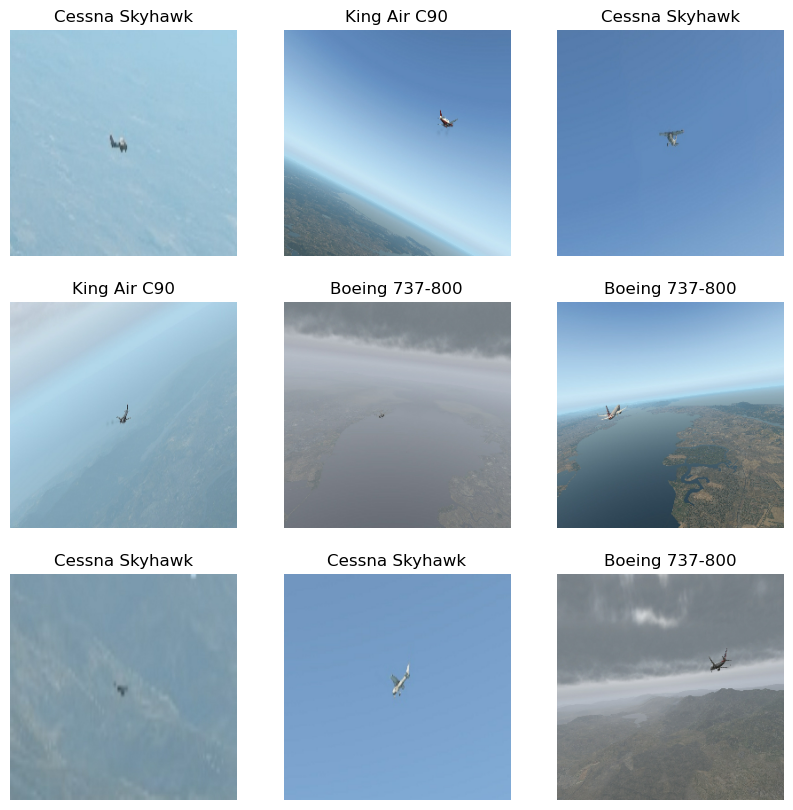

In [10]:
# test visualise 
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_aug_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
def one_hot_enc(image, label):
    return image, tf.one_hot(label, len(class_names))

train_data = train_data.map(one_hot_enc)
train_aug_data = train_aug_data.map(one_hot_enc)
valid_data = valid_data.map(one_hot_enc)


In [12]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32, 3)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000, seed=42).prefetch(buffer_size=AUTOTUNE)
train_aug_data = train_aug_data.cache().shuffle(1000, seed=42).prefetch(buffer_size=AUTOTUNE)

valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)


In [14]:
# get list of validation labels for evaluation
validation_labels = []
for images, labels in valid_data:
    validation_labels.append(labels.numpy())

validation_labels = np.concatenate(validation_labels)

In [15]:
# model

def get_model(): 
  num_classes = len(class_names)

  model = Sequential([
    Input(shape=(img_height, img_width, 3)),
    Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),     
    Dense(num_classes, activation='softmax') 
  ])
  
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

  #model.summary()
  
  return model


In [16]:
# Train Pure

# local logs directory
logs_dir=cfg.CLF_PROJECT_DIR
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

#connect to clearml
task = Task.init(project_name=project_name, task_name=f"{dataset_name}-pure-eps:{epochs}-zf:{zoom_factor}")
logger = task.get_logger()

# clearml hyperparameters
hyper_params = {'epochs': epochs, 'zoom_factor': zoom_factor, 'batch_size': batch_size, 'img_height': img_height, 'img_width': img_width, 'class_names': class_names}
task.connect(hyper_params)

# ensure model from scratch and get model

model = get_model()

# train model
print('Training model...')
train_hst = model.fit(
    train_data, 
    epochs=hyper_params['epochs'], 
    validation_data=valid_data,
    callbacks=[tensorboard_callback]
    )

# predict on validation set
print('Predicting on validation set...')
y_pred = model.predict(valid_data)

# evaluate
pure_eval = Evaluate(train_hst, validation_labels, y_pred, class_names, aug=False, sf=3)

# send metrics to clearML
pure_eval.log_metrics(task, logger, N)


# close task
print("done")


ClearML Task: created new task id=1bc2b108b5b2481ea9816f41721190ef
2024-04-29 05:13:22,472 - clearml.Task - INFO - Storing jupyter notebook directly as code


ClearML results page: https://app.clear.ml/projects/7e589bc2db6e4e3ba6e0ae59cc527576/experiments/1bc2b108b5b2481ea9816f41721190ef/output/log
Training model...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - accuracy: 0.2875 - loss: 3.0446 - precision: 0.3241 - recall: 0.1436 - val_accuracy: 0.3300 - val_loss: 1.0998 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/step - accuracy: 0.3541 - loss: 1.0990 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3300 - val_loss: 1.0987 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - accuracy: 0.3651 - loss: 1.1028 - precision: 0.1381 - recall: 0.0036 - val_accuracy: 0.3300 - val_loss: 1.0987 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
16/16 ━━━

In [17]:
# Train Augmented

# local logs directory, callbacks allow for real time metrics in clearML
logs_dir=cfg.CLF_PROJECT_DIR
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

#connect to clearml
task = Task.init(project_name=project_name, task_name=f"{dataset_name}-aug-eps:{epochs}-zf:{zoom_factor}")
logger = task.get_logger()


# clearml hyperparameters
hyper_params = {'epochs': epochs, 'zoom_factor': zoom_factor, 'batch_size': batch_size, 'img_height': img_height, 'img_width': img_width, 'class_names': class_names}
task.connect(hyper_params)

# ensure model from scratch and get model
model_aug = get_model()

# train model
print('Training model...')
train_aug_hst = model_aug.fit(
    train_aug_data, 
    epochs=hyper_params['epochs'], 
    validation_data=valid_data, 
    callbacks=[tensorboard_callback]
    )

# predict on validation set
print('Predicting on validation set...')
y_pred_aug = model_aug.predict(valid_data)

# evaluate
aug_eval = Evaluate(train_aug_hst, validation_labels, y_pred_aug, class_names, aug=True, sf=3)

# send metrics to clearML
aug_eval.log_metrics(task, logger, N) 
 
# close task
print("done")


ClearML Task: created new task id=75f6a31c9d504a1fa0cf57881b5aa50a
ClearML results page: https://app.clear.ml/projects/7e589bc2db6e4e3ba6e0ae59cc527576/experiments/75f6a31c9d504a1fa0cf57881b5aa50a/output/log
Training model...
Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.3256 - loss: 2.7888 - precision: 0.2958 - recall: 0.1401 - val_accuracy: 0.3300 - val_loss: 1.0978 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - accuracy: 0.3434 - loss: 1.0987 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3300 - val_loss: 1.0985 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - accuracy: 0.3427 - loss: 1.0983 - precision: 0.1200 - recall: 3.5177e-04 - val_accuracy: 0.3300 - val_loss: 1.1002 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.3545 - loss: 1.0949 - precision: 0.8800 - 

In [18]:
#task.close()

# Evaluation

All metrics have been fully logged in ClearML, this section is just for quick performance metrics not complete evaluation

In [19]:
# pure accuracy

#pure_eval.average_accuracy(True)
#print()
#pure_eval.std_accuracy(True)
#print()
pure_eval.best_accuracy(True)
print()
#pure_eval.last_accuracy(True)
#print()



Best Accuracy - pure: 0.414
Best Val Accuracy - pure: 0.45



In [20]:
# augmented accuracy

#aug_eval.average_accuracy(True)
#print()
#aug_eval.std_accuracy(True)
#print()
aug_eval.best_accuracy(True)
print()
#aug_eval.last_accuracy(True)
#print()


Best Accuracy - augmented: 0.576
Best Val Accuracy - augmented: 0.61



In [21]:
# Area under the ROC curve 
pure_eval.overall_auc(True)
aug_eval.overall_auc(True)
print()

Overall AUC - pure: 0.61
Overall AUC - augmented: 0.803



In [22]:
# Max validation F1 score 
pure_eval.max_f1(True)
aug_eval.max_f1(True)
print()

Max F1 score - pure:  0  at epoch:  0
Max F1 score - augmented:  0.506  at epoch:  19



In [23]:
# loss

# minimum vakidation loss
#pure_eval.min_loss(True)
#aug_eval.min_loss(True)
#print()

# difference in average loss between training and validation sets for the last N epochs
pure_eval.diff_avg_loss_lastN(N,True)
aug_eval.diff_avg_loss_lastN(N,True)
print()

# standard deviation of loss for the last N epochs
#pure_eval.std_loss_lastN(N,True)
#aug_eval.std_loss_lastN(N,True)
#print()




Diff Avg Loss - pure: -0.002
Diff Avg Loss - augmented: -0.004



# Class Specific Evaluation

In [24]:
# pure class auc

#pure_eval.confusion_matrix_class_report(False)
#print()

pure_eval.class_auc(True)
print()


AUC per class - pure:

  Boeing 737-800: 0.678
  Cessna Skyhawk: 0.682
  King Air C90: 0.469



In [25]:
# augmented class auc
#aug_eval.confusion_matrix_class_report(True)
#print()

aug_eval.class_auc(True)    
print()



AUC per class - augmented:

  Boeing 737-800: 0.734
  Cessna Skyhawk: 0.835
  King Air C90: 0.839

